### INITIALIZATION

In [2]:
# Import external libraries:
import numpy as np
import skfem as sk
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import copy as copy

# Import external functions:
from skfem.helpers import dot, grad
from scipy.sparse.linalg import splu
from skfem.visuals.matplotlib import plot

### PROBLEM PARAMETERS

In [4]:
# Define problem size:
length_T  = 350.0  # [cm]  Total loop length
length_Hi = 000.0  # [cm]  Core intial point coordinate
length_Hf = 150.0  # [cm]  Core final point coordinate
length_Li = 150.0  # [cm]  Heat-exchanger initial point coordinate
length_Lf = 350.0  # [cm]  Heat-exchanger final point coordinate

# Define region identifier:
reg_H = lambda x: (x<length_Hf) * (x>=length_Hi)     # Core region identifier
reg_L = lambda x: (x<length_Lf) * (x>=length_Li)     # Heat-exchanger region identifier

# Define mesh discretization
mesh_width = 1.0                                     # [cm]  Mesh element width 
mesh_steps = int(length_T/mesh_width)                # [-]   Number of mesh intervals
mash_nodes = np.linspace(0, length_T, mesh_steps+1)  # [cm]  Coordinates of the mesh nodes
polynomial_order = 1                                 #       Polinomial order for Galerkin discretization:

# Define continuous Galerkin discretization:
if polynomial_order==1 : line_element = sk.element.ElementLineP1()
if polynomial_order==2 : line_element = sk.element.ElementLineP2()
line_basis = sk.Basis(sk.MeshLine(mash_nodes), line_element)
ndof = line_basis.N - 1

# Define time discretization:
time_width = 0.01                         # [s]  Time step width
time_horiz = 1000                         # [s]  Time horizon 
time_steps = int(time_horiz/time_width)   # [-]  Number of time steps
theta = 0.50                              #      Integration scheme (1.0: implicit, 0.5: Crank-Nicolson, 0.0: explicit)
supg = True                               #      Use supg stabilization or no:

In [7]:
# Neutron and precurson equation parameters (except cross sections and thermal coupling therms):
vv = 2.2000e+5   # [cm s^-1]            Speed mono-energetic neutrons
bb = 5.4700e-3   # [1]                  Delayed neutron fraction                     
nu = 2.4355e+0   # [1]                  Neutron fission yeld                                 
ll = 8.0000e-2   # [s^-1]               Decay constant of delayed neutron precursors
uu = 1.0000e+1   # [cm s^-1]            Velocity of the fuel inside the reactor

# Energy equation parameters (except cross section and thermal coupling terms:
cp = 1.9670e-0   # [J g^-1 K^-1]        Specific heat capacity of the fuel
ro = 2.2580e-0   # [g cm^-3]            Density of the fuel at reference temperature ignoring termal variations
kk = 1.4350e-2   # [J cm^−1 K^−1 s^-1]  Heat conductivity of the fuel  
ed = 1.4219e-12  # [J]                  Energy released per prursor decay
ef = 3.0217e-11  # [J]                  Energy released per fission event
hh = 5.0000e-1   # [J cm^-2 K^-1 s^-1]  Heat exchanger coefficient on the heat exchanger
wp = 4.4108e+2   # [cm]                 Heat exchanger wetted perimeter (or 70.2 cm)
wa = 1.5481e+4   # [cm^2]               Average core section (used to compute the linear power)

# Reference macroscopic cross sections and neutron diffusivity at temperature T0:
sf = 1.8189e-3   # [cm^-1]              Macroscopic fission cross section at reference temperature 
sa = 3.7600e-3   # [cm^-1]              Macroscopic absorption cross section at reference temperature 
dd = 1.2100e+0   # [cm]                 Neutron diffusion coefficient at reference temperature 

# Termal coupling parameters:
T0 = 9.2200e+2   # [K]                  Reference temperature 
Th = 8.2000e+2   # [K]                  Temperature of the reservoir
Ph = 8.0000e+6   # [W]                  Global thermal power of the reactor
aa = 2.1200e-4   # [K^-1]               Thermal expansion coefficient 

### PROBLEM FORMS DEFINITION

In [10]:
# Define periodic coordinates and ordered coordinates:
list_col = np.array(list(range(mesh_steps)) + list(range(mesh_steps+1, polynomial_order*mesh_steps+1)))
list_ord = np.hstack([[ii + jj*mesh_steps for jj in range(polynomial_order)] for ii in range(mesh_steps)])

# Convert periodic vector into standard domain:
def get_standard_vector(vector): 
    return np.hstack((vector[:mesh_steps], vector[0], vector[mesh_steps:]))

# Convert standard vector into periodic domain:
def get_periodic_vector(vector): 
    vector[0] += vector[mesh_steps]
    return vector[list_col]

# Convert continuous Galerkin matrix to periodic form:
def get_periodic_matrix(matrix):
    matrix = sparse.lil_matrix(matrix)
    matrix[:, 0] += matrix[:, mesh_steps]
    matrix[0, :] += matrix[mesh_steps, :]
    return sparse.csc_matrix(matrix[list_col, :][:, list_col])

In [12]:
# Define zero matrix:
ZZ_T = sparse.csc_matrix((ndof, ndof))

# Define mass bilinear form on the core region:
@sk.BilinearForm
def get_mm_H(u, v, w): return reg_H(w.x[0]) * u * (v + supg * mesh_width * grad(v)[0] / 2)
MM_H = get_periodic_matrix(get_mm_H.assemble(line_basis))

# Define mass bilinear form on the heat-exchanger region:
@sk.BilinearForm
def get_mm_L(u, v, w): return reg_L(w.x[0]) * u * (v + supg * mesh_width * grad(v)[0] / 2)
MM_L = get_periodic_matrix(get_mm_L.assemble(line_basis))

# Define mass bilinear form on the full domain:
@sk.BilinearForm 
def get_mm_T(u, v, _): return u * (v + supg * mesh_width * grad(v)[0] / 2)
MM_T = get_periodic_matrix(get_mm_T.assemble(line_basis))

# Define global advection bilinear form for continuous Galerkin:
@sk.BilinearForm
def get_aa_T(u, v, _): return grad(u)[0] * (v + supg * mesh_width * grad(v)[0] / 2)
AA_T = get_periodic_matrix(get_aa_T.assemble(line_basis))

# Define global diffusion bilinear form for continuous Galerkin:
@sk.BilinearForm
def get_kk_T(u, v, _): return dot(grad(u), grad(v))
KK_T = get_periodic_matrix(get_kk_T.assemble(line_basis))

# Define linear functional on the heat-exchanger region:
@sk.LinearForm
def get_vv_L(v,w): return reg_L(w.x[0]) * (v + supg * mesh_width * grad(v)[0] / 2)
vv_L = get_periodic_vector(get_vv_L.assemble(line_basis))

# Define mass bilinear form on the core region:
@sk.BilinearForm
def get_mass(u, v, w): return u * v
mass = get_periodic_matrix(get_mass.assemble(line_basis))

In [14]:
# Define reference temperature field
T0_periodic = T0 * np.ones((ndof))
ref_T  = line_basis.interpolate(get_standard_vector(T0_periodic))

# Define non-linear interaction term for the reaction term:
def get_mm_FT_T(periodic_T, basis=line_basis):
    cur_T = basis.interpolate(get_standard_vector(periodic_T))
    cur_Y = np.sqrt(ref_T/cur_T) * np.exp(-aa*(cur_T-ref_T))
    @sk.BilinearForm
    def mm_FT_T_assembler(u, v, _): return cur_Y * u * (v + supg * mesh_width * grad(v)[0] / 2)
    return  get_periodic_matrix(mm_FT_T_assembler.assemble(basis))
    
# Define non-linear interaction term for the reaction term:
def get_mm_FT_H(periodic_T, basis=line_basis):
    cur_T = basis.interpolate(get_standard_vector(periodic_T))
    cur_Y = np.sqrt(ref_T/cur_T) * np.exp(-aa*(cur_T-ref_T))
    @sk.BilinearForm
    def mm_FT_H_assembler(u, v, w): return reg_H(w.x[0]) * cur_Y * u * (v + supg * mesh_width * grad(v)[0] / 2)
    return  get_periodic_matrix(mm_FT_H_assembler.assemble(basis))

# Define non-linear interaction term for the reaction term:
def get_kk_FT_T(periodic_T, basis=line_basis):
    cur_T = basis.interpolate(get_standard_vector(periodic_T))
    cur_Y = np.sqrt(ref_T/cur_T) * np.exp( aa*(cur_T-ref_T))
    @sk.BilinearForm
    def kk_FT_T_assembler(u, v, _): return cur_Y * dot(grad(u), grad(v))
    return  get_periodic_matrix(kk_FT_T_assembler.assemble(basis))

# Define linear functional on the full domain:
def get_vv_FT_T(periodic_G, basis=line_basis):
    cur_G = basis.interpolate(get_standard_vector(periodic_G))
    @sk.LinearForm
    def get_vv_FT_T(v, _): return cur_G * (v + supg * mesh_width * grad(v)[0] / 2)
    return get_periodic_vector(get_vv_FT_T.assemble(basis))

# Define linear functional on the full domain:
def get_vv_FT_H(periodic_G, basis=line_basis):
    cur_G = basis.interpolate(get_standard_vector(periodic_G))
    @sk.LinearForm
    def get_vv_FT_H(v, w): return reg_H(w.x[0]) * cur_G * (v + supg * mesh_width * grad(v)[0] / 2)
    return get_periodic_vector(get_vv_FT_H.assemble(basis))

In [16]:
# Define non-linear interaction term for the reaction term:
def get_vm_FT_T(periodic_F, periodic_T):
    cur_F = line_basis.interpolate(get_standard_vector(periodic_F))
    cur_T = line_basis.interpolate(get_standard_vector(periodic_T))
    @sk.LinearForm
    def vm_FT_T_assembler(v, _): return (1 - np.sqrt(ref_T/cur_T) * np.exp(-aa*(cur_T-ref_T))) * cur_F * (v + supg * mesh_width * grad(v)[0] / 2)
    return  get_periodic_vector(vm_FT_T_assembler.assemble(line_basis))
    
# Define non-linear interaction term for the reaction term:
def get_vm_FT_H(periodic_F, periodic_T):
    cur_F  = line_basis.interpolate(get_standard_vector(periodic_F))
    cur_T  = line_basis.interpolate(get_standard_vector(periodic_T))
    @sk.LinearForm
    def vm_FT_H_assembler(v, w): return reg_H(w.x[0]) * (1 - np.sqrt(ref_T/cur_T) * np.exp(-aa*(cur_T-ref_T))) * cur_F * (v + supg * mesh_width * grad(v)[0] / 2)
    return  get_periodic_vector(vm_FT_H_assembler.assemble(line_basis))

# Define non-linear interaction term for the reaction term:
def get_vk_FT_T(periodic_F, periodic_T):
    cur_F = line_basis.interpolate(get_standard_vector(periodic_F))
    cur_T = line_basis.interpolate(get_standard_vector(periodic_T))
    @sk.LinearForm
    def vk_FT_T_assembler(v, _): return (1 - np.sqrt(ref_T/cur_T) * np.exp(aa*(cur_T-ref_T))) * dot(grad(cur_F), grad(v))
    return  get_periodic_vector(vk_FT_T_assembler.assemble(line_basis))

### COUPLED PROBLEM STEADY STATE

In [19]:
# Define norm for the single field and for all the fields:
norm_one = lambda x: np.sqrt(mass.dot(x).dot(x))
norm_all = lambda x: np.sqrt(norm_one(x[0*ndof:1*ndof])**2 + norm_one(x[1*ndof:2*ndof])**2 + norm_one(x[2*ndof:3*ndof])**2)

# Initialise flux, precursors and temperature field:
fct_std = np.zeros((3*ndof))
fct_std[2*ndof:3*ndof] = T0

# Enter the main loop:
glob_error = 1
while glob_error > 1e-8:
    old_fct_std = copy.deepcopy(fct_std)

    # Update the temperature dependent absorption, fission and diffusion bilinear forms:
    MM_FT_T = get_mm_FT_T(fct_std[2*ndof:3*ndof])
    MM_FT_H = get_mm_FT_H(fct_std[2*ndof:3*ndof])
    KK_FT_T = get_kk_FT_T(fct_std[2*ndof:3*ndof])

    # Assemble the matrices of the static flux-precursor eigenvalue problem:
    AA_matrix = sparse.csc_matrix(sparse.bmat([[ sa * MM_FT_T + dd * KK_FT_T, - ll * MM_T], [ZZ_T,    uu * AA_T + ll * MM_T]]))
    BB_matrix = sparse.csc_matrix(sparse.bmat([[(1 - bb) * nu * sf * MM_FT_H,        ZZ_T], [bb * nu * sf * MM_FT_H,   ZZ_T]]))
    
    # Compute the current multiplication factor and the flux-precursors eigenstate:
    k_eff, f_eff = sparse.linalg.eigs(AA_matrix.T @ BB_matrix, M=AA_matrix.T @ AA_matrix, which='LM', k=1)
    k_eff, fct_std[0*ndof:2*ndof] = np.real(k_eff)[0], np.real(f_eff[:, 0])
    
    # Enter the thermal coupling sub-loop:
    temp_error = 1
    while temp_error > 1e-8:
        old_t = copy.deepcopy(fct_std[2*ndof:3*ndof])

        # Update the fission bilinear form:
        MM_FT_H = get_mm_FT_H(fct_std[2*ndof:3*ndof])

        # Compute the energy equation forcing term for the prescribed power level:  (ASK JEAN ABOUT 1/k_eff)
        gener = (sf / k_eff) * ef * MM_FT_H @ fct_std[0*ndof:1*ndof] + ll * ed * MM_T @ fct_std[1*ndof:2*ndof]
        coeff = (Ph / wa) / mass.dot(sparse.linalg.spsolve(MM_T, gener)).dot(np.ones(ndof))
        other = coeff * gener + Th * (hh / wp) * MM_L.dot(np.ones(ndof))
        
        # Compute the temperature profile at current power level and with the last updated flux and precursor solution:
        fct_std[0*ndof:2*ndof] = coeff * fct_std[0*ndof:2*ndof]
        fct_std[2*ndof:3*ndof] = sparse.linalg.spsolve(uu * ro * cp * AA_T + kk * KK_T + (hh / wp) * MM_L, other)
        
        # Compute the error on the temperature evaluation in the thermal coupling sub-loop:
        temp_error = norm_one(fct_std[2*ndof:3*ndof] - old_t) / norm_one(fct_std[2*ndof:3*ndof])

    # Compute the error on all the three fields at the current iteration of the main loop:
    glob_error = norm_one(fct_std[0*ndof:1*ndof] - old_fct_std[0*ndof:1*ndof]) / norm_one(fct_std[0*ndof:1*ndof]) \
               + norm_one(fct_std[1*ndof:2*ndof] - old_fct_std[1*ndof:2*ndof]) / norm_one(fct_std[1*ndof:2*ndof]) \
               + norm_one(fct_std[2*ndof:3*ndof] - old_fct_std[2*ndof:3*ndof]) / norm_one(fct_std[2*ndof:3*ndof])

k_eff = 0.9855058268676473 



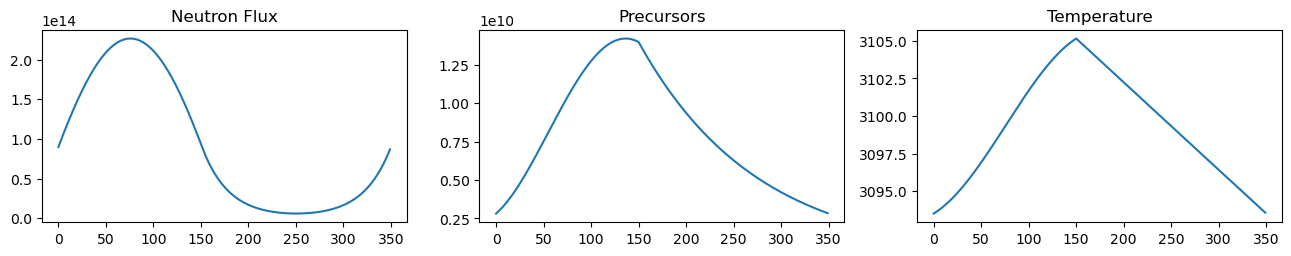

In [20]:
print("k_eff =", k_eff, "\n")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(16, 2.5, forward=True)
ax1.plot(mash_nodes[:-1], fct_std[0*ndof:1*ndof])
ax1.set_title("Neutron Flux")
ax2.plot(mash_nodes[:-1], fct_std[1*ndof:2*ndof])
ax2.set_title("Precursors")
ax3.plot(mash_nodes[:-1], fct_std[2*ndof:3*ndof])
ax3.set_title("Temperature")
plt.show()

### NEUTRONIC PROBLEM TIME EVOLUTION

In [24]:
# Define a pump defect factor:
pdf = 0.5

# Define diffusion and reaction coefficients for the neutron equation:
mm_FF_H = - vv * (1 - bb) * nu * sf / k_eff   # Neutron fission coefficient on the core region only
mm_FF_T =   vv * sa                           # Neutron absorpiton coefficient on the whole domain
kk_FF_T =   vv * dd                           # Neutron diffusion coefficient on the whole domain
mm_FC_T = - vv * ll                           # Precursor decay coefficient on the whole domain (coupling F and C)

# Define diffusion, advection and reaction coefficients for the neutron equation:
mm_CF_H = - bb * nu * sf / k_eff              # Neutron fission source term localised on the core region (coupling C and F)
mm_CC_T =   ll                                # Precursor decay coefficient
aa_CC_T =   uu * pdf                          # Precursor advection velocity
kk_CC_T =   1e-6                              # Artificial stabilising diffusivity

# Define diffusion, advection and reaction coefficients for the energy equation:
aa_TT_T =   uu * pdf                          # Thermal advection velocity (HALF OF STEADY STATE ONE)
kk_TT_T =   kk / (ro * cp)                    # Thermal diffusion coefficient  (thermal diffusivity)
mm_TT_L =   hh / (ro * cp * wp)               # Thermal removal power coefficient in the heat-exchanger region
mm_TF_H = - ef * (sf / k_eff) / (ro * cp)     # Thermal reaction energy from fuel fission (coupling T and F)
mm_TC_T = - ed * ll / (ro * cp)               # Thermal decay energy from the precursor (coupling T and C)

In [26]:
# Define linear and bi-linear forms for the neutron and precursor transport problem:
MM_FC = sparse.csc_matrix(sparse.bmat([[MM_T, ZZ_T], [ZZ_T, MM_T]]))
SS_FC = sparse.csc_matrix(sparse.bmat([[mm_FF_H*MM_H + mm_FF_T*MM_T + kk_FF_T*KK_T,  mm_FC_T*MM_T], [mm_CF_H*MM_H,  mm_CC_T*MM_T + aa_CC_T*AA_T + kk_CC_T*KK_T]]))
FF_FC = lambda x: np.hstack((mm_FF_H * get_vm_FT_H(x[0*ndof:1*ndof], x[2*ndof:3*ndof]) + mm_FF_T * get_vm_FT_T(x[0*ndof:1*ndof], x[2*ndof:3*ndof]) 
                           + kk_FF_T * get_vk_FT_T(x[0*ndof:1*ndof], x[2*ndof:3*ndof]),  mm_CF_H * get_vm_FT_H(x[0*ndof:1*ndof], x[2*ndof:3*ndof])))

# Define left and right hand side matrices of the neutron flux and the precursor problem:
AA_FC = MM_FC +      theta  * SS_FC * time_width
BB_FC = MM_FC - (1 - theta) * SS_FC * time_width

# Define left and right hand side operators:
LHS_FC = sparse.linalg.splu(AA_FC).solve
RHS_FC = lambda x, y: BB_FC.dot(x[:2*ndof]) + FF_FC(y) * time_width

In [28]:
# Define linear and bi-linear forms for the energy problem:
MM_TT = MM_T
SS_TT = kk_TT_T * KK_T + mm_TT_L * MM_L + aa_TT_T * AA_T
FF_TT = lambda x: - mm_TC_T * get_vv_FT_T(x[1*ndof:2*ndof]) - mm_TF_H * get_vv_FT_H(x[0*ndof:1*ndof]) \
                  + mm_TF_H * get_vm_FT_H(x[0*ndof:1*ndof], x[2*ndof:3*ndof]) + mm_TT_L * vv_L * Th

# Define left and right hand side matrices of the energy problem:
AA_TT = MM_TT +      theta  * SS_TT * time_width
BB_TT = MM_TT - (1 - theta) * SS_TT * time_width

# Define left and right hand side operators:
LHS_TT = sparse.linalg.splu(AA_TT).solve
RHS_TT = lambda x, y: BB_TT.dot(x[2*ndof:]) + FF_TT(y) * time_width

In [ ]:
# Initialise solution array:
solution_FCT = np.ones((3*ndof, time_steps+1))
solution_FCT[:, 0] = fct_std

# Enter time loop:
for ii in range(1, time_steps+1):
    solution_FCT[:, ii] = solution_FCT[:, ii-1] 

    # Enter fixed point sub-loop:
    error = 1
    while error > 1e-4:
        old_estimate = copy.deepcopy(solution_FCT[:, ii])

        # Compute the current time and sub-loop iteration solution:
        solution_FCT[0*ndof:2*ndof, ii] = LHS_FC(RHS_FC(solution_FCT[:, ii-1], theta*solution_FCT[:, ii] + (1-theta)*solution_FCT[:, ii-1]))
        solution_FCT[2*ndof:3*ndof, ii] = LHS_TT(RHS_TT(solution_FCT[:, ii-1], theta*solution_FCT[:, ii] + (1-theta)*solution_FCT[:, ii-1]))
        
        # Compute the fixed point error:
        error = norm_all(solution_FCT[:, ii] - old_estimate) / norm_all(solution_FCT[:, ii]) 

In [ ]:
nn = -1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(16, 2.5, forward=True)
ax1.plot(mash_nodes[:-1], solution_FCT[0*ndof:1*ndof, 0])
ax1.plot(mash_nodes[:-1], solution_FCT[0*ndof:1*ndof, nn])
ax1.set_title("Neutron Flux")
ax2.plot(mash_nodes[:-1], solution_FCT[1*ndof:2*ndof, 0])
ax2.plot(mash_nodes[:-1], solution_FCT[1*ndof:2*ndof, nn])
ax2.set_title("Precursors")
ax3.plot(mash_nodes[:-1], solution_FCT[2*ndof:3*ndof, 0])
ax3.plot(mash_nodes[:-1], solution_FCT[2*ndof:3*ndof, nn])
ax3.set_title("Temperature")
plt.show()

### A REFERENCE FULL IMPLICIT SCHEME (DEVELOPMENT TEST)

In [ ]:
# Initialise initial conditions and enter time iteration loop:
fct_dyn = np.zeros((3*ndof, time_steps+1))
fct_dyn[:, 0] = copy.deepcopy(fct_std)
fct_dyn[:, 1] = copy.deepcopy(fct_std)

# Define global mass matrix and forcing term:
MM_FCT = sparse.csc_matrix(sparse.bmat([[MM_T, ZZ_T, ZZ_T], [ZZ_T, MM_T, ZZ_T], [ZZ_T, ZZ_T, MM_T]]))
FF_FCT = np.hstack((np.zeros(ndof), np.zeros(ndof), Th * mm_TT_L * vv_L))

# Enter the main loop
for ii in range(1, time_steps+1):
    fct_dyn[:, ii] = fct_dyn[:, ii-1]  

    # Use a full implicit scheme to find a reference solution:
    error = 1
    while error > 1e-4:
        old_estimate = copy.deepcopy(fct_dyn[:, ii])

        # Assemble termal coupling matrices:
        MM_FT_H = get_mm_FT_H(old_estimate[2*ndof:3*ndof])
        MM_FT_T = get_mm_FT_T(old_estimate[2*ndof:3*ndof])
        KK_FT_T = get_kk_FT_T(old_estimate[2*ndof:3*ndof])

        # Define global bilinear form:
        SS_FCT = sparse.csc_matrix(sparse.bmat(
               [[mm_FF_H*MM_FT_H + mm_FF_T*MM_FT_T + kk_FF_T*KK_FT_T,  mm_FC_T*MM_T,            ZZ_T], 
                [mm_CF_H*MM_FT_H,  kk_CC_T*KK_T    + aa_CC_T*AA_T    + mm_CC_T*MM_T,            ZZ_T],
                [mm_TF_H*MM_FT_H,  mm_TC_T*MM_T,     kk_TT_T*KK_T    + mm_TT_L*MM_L + aa_TT_T * AA_T]])) 

        # Solve current time step iteration and compute the error in the sub-loop:
        fct_dyn[:, ii] = sparse.linalg.spsolve(MM_FCT +  SS_FCT * time_width, MM_FCT.dot(fct_dyn[:, ii-1]) + FF_FCT * time_width)
        error = norm_all(fct_dyn[:, ii] - old_estimate) / norm_all(fct_dyn[:, ii]) 

In [ ]:
nn = -1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(16, 2.5, forward=True)
ax1.plot(mash_nodes[:-1], fct_dyn[0*ndof:1*ndof, 0])
ax1.plot(mash_nodes[:-1], fct_dyn[0*ndof:1*ndof, nn])
ax1.set_title("Neutron Flux")
ax2.plot(mash_nodes[:-1], fct_dyn[1*ndof:2*ndof, 0])
ax2.plot(mash_nodes[:-1], fct_dyn[1*ndof:2*ndof, nn])
ax2.set_title("Precursors")
ax3.plot(mash_nodes[:-1], fct_dyn[2*ndof:3*ndof, 0])
ax3.plot(mash_nodes[:-1], fct_dyn[2*ndof:3*ndof, nn])
ax3.set_title("Temperature")
plt.show()